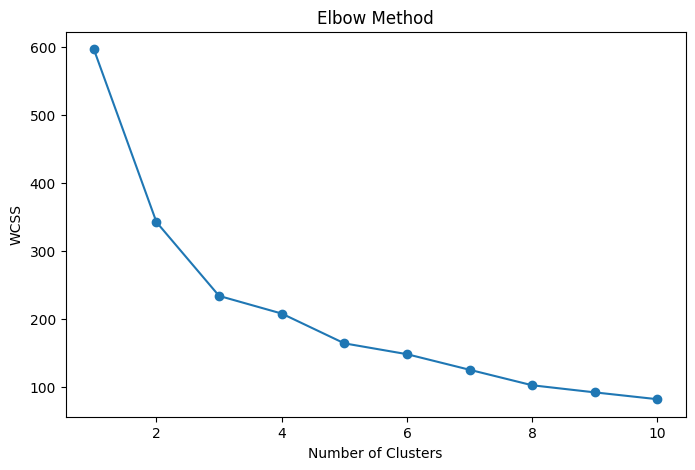

Davies-Bouldin Index: 0.9467058109377833
Silhouette Score: 0.30894183464214525


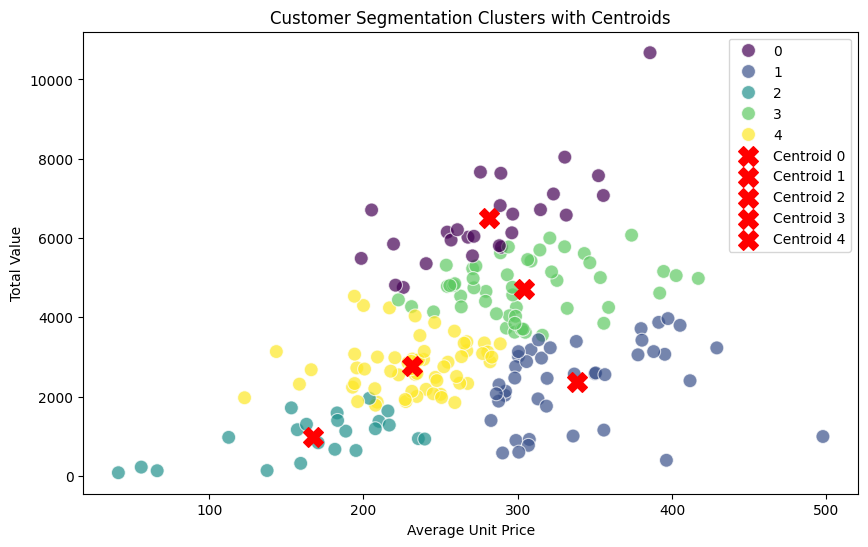

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

transactions = pd.read_csv('transactions.csv')
products = pd.read_csv('products.csv')
customers = pd.read_csv('customers.csv')

if 'Price' in products.columns:
    products.rename(columns={'Price': 'UnitPrice'}, inplace=True)

merged_data = transactions.merge(products, on='ProductID', how='inner').merge(customers, on='CustomerID', how='inner')

if 'UnitPrice' not in merged_data.columns:
    raise KeyError("'UnitPrice' column is missing in the merged data.")

merged_data['TotalValue'] = merged_data['Quantity'] * merged_data['UnitPrice']

features = merged_data.groupby('CustomerID').agg({
    'UnitPrice': 'mean',
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['UnitPrice', 'Quantity', 'TotalValue']])

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

features['Cluster'] = clusters

db_index = davies_bouldin_score(scaled_features, clusters)
sil_score = silhouette_score(scaled_features, clusters)
print('Davies-Bouldin Index:', db_index)
print('Silhouette Score:', sil_score)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=features['UnitPrice'],
    y=features['TotalValue'],
    hue=features['Cluster'],
    palette='viridis',
    s=100,
    alpha=0.7
)

centroids = scaler.inverse_transform(kmeans.cluster_centers_)
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[2], c='red', s=200, marker='X', label=f'Centroid {i}')
    
plt.title('Customer Segmentation Clusters with Centroids')
plt.xlabel('Average Unit Price')
plt.ylabel('Total Value')
plt.legend()
plt.show()